<a target="_blank" href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Duffin_oscillator/Plots/Duffin_Oscillator_FEM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

#  Duffing oscillator process in a ball of $\mathbb{R}^2$ : computation of solutions using Finite Element Method

Based on the paper [A neural network solution of first-passage problems](https://link.springer.com/article/10.1007/s10483-024-3189-8) (Jiamin Qian, Lincong Chen & J. Q. Sun, Oct. 2024), the 2-dimensional Duffing oscillator is defined by:
$$ d \begin{pmatrix} X_1(t)\\
X_2(t) \end{pmatrix} = \begin{pmatrix} X_2\\
-X_1 - X_1^3 - 2\zeta X_2 \end{pmatrix} dt + \begin{pmatrix} \sqrt{2\varepsilon}dB_1(t)\\
\sqrt{2\zeta} dB_2(t) \end{pmatrix}$$

The infinitesimal generator of this process is given for sufficiently smooth $f$ by
$$\mathscr Lf: x \mapsto b(x) \cdot \nabla f(x) + a(x) : \nabla^2 f(x)$$
where
$$b : x = (x_1, x_2)^T \mapsto \begin{pmatrix} x_2\\ -x_1 - x_1^3 - 2\zeta x_2 \end{pmatrix}  $$
and
$$a:x \mapsto \frac12 \sigma(x)\sigma(x)^T = \begin{pmatrix} \varepsilon & 0\\ 0 & \zeta\end{pmatrix} $$

## 1) The PDE problem

The Mean Escape Time (MET) $\tau$ is solution of the following elliptic problem

$$\begin{cases}\mathscr L\tau = -1 \quad \text{in } \Omega,\\
\tau= 0 \quad\text{ on }\partial\Omega\end{cases} $$

##2) The variational formulation

Because $\mathscr L$ is a second-order elliptic operator, we need to use integration by parts to make the PDE solvable in a traditional FEM solver. To do so, we multiply the PDE with a test function $v\in \hat V$, which belongs in the test function space $\hat V$. We then integrate over $\Omega$:
$$\begin{align*}\int_\Omega\mathscr L\tau\cdot v = -\int_\Omega v &\implies \int_\Omega \Big(x_2\partial_{x_1}\tau(x) - (x_1 + x_1^3 + 2\zeta x_2)\partial_{x_2} \tau(x) + \varepsilon \partial^2_{x_1,x_1}\tau(x) + \zeta \partial^2_{x_2,x_2}\tau(x) + 1\Big)v(x)dx = 0 \end{align*} $$

The first order derivatives of $\tau$ can be handled just fine by the solver, but the second order derivatives can't, hence we apply integration by parts to get the following weak formulation:

$$\int_\Omega \Big[\Big(x_2\partial_{x_1}\tau(x) - (x_1 + x_1^3 + 2\zeta x_2)\partial_{x_2} \tau(x)\Big)v(x) - \varepsilon \partial_{x_1}\tau(x)\partial_{x_1}v(x) - \zeta \partial_{x_2}\tau(x)\partial_{x_2}v(x)\Big] dx = - \int_\Omega v(x) dx$$

Which can be equivalently rewritten as

$$ a[\tau, v] = L(v) $$

Where $a$ is the bilinear form defined as

$$a : (\tau, v)\mapsto \int_\Omega \Big[\Big(x_2\partial_{x_1}\tau(x) - (x_1 + x_1^3 + 2\zeta x_2)\partial_{x_2} \tau(x)\Big)v(x) - \varepsilon \partial_{x_1}\tau(x)\partial_{x_1}v(x) - \zeta \partial_{x_2}\tau(x)\partial_{x_2}v(x)\Big] dx, $$

which equivalently reads

$$a : (\tau, v)\mapsto \int_\Omega \nabla\tau(x) \cdot b(x) v(x) - \text{diag}(\varepsilon, \zeta)\nabla\tau(x)\cdot\nabla v(x) dx$$

and $L$ is the linear form defined as

$$L : v\mapsto - \int_\Omega v(x) dx $$

## 3) FEniCS implementation

In [ ]:
from fenics import * #???
from mshr import * #??

In [ ]:
#create mesh and define function space
radius = 2
domain = Circle(Point(0, 0), radius)
mesh = generate_mesh(domain, 64)
V = FunctionSpace(mesh, 'P', 1)

#define boundary conditions


#define variational problem
tau = TrialFunction(V)
v = TestFunction(V)


In [ ]:
#Duffin-oscillator process in same ball
zeta = 0.08
eps = 10**-5
do_1 = [x_0[0]]
do_2 = [x_0[1]]
current_norm = 0
current_steps = 1

while current_norm < r :
    update_1 = do_2[-1]*dt + np.sqrt(2*eps)*np.random.normal(scale=np.sqrt(dt))
    update_2 = -(do_1[-1] + do_1[-1]**3 + 2*zeta*do_2[-1])*dt  \
        + np.sqrt(2 * zeta) *np.random.normal(scale=np.sqrt(dt))
    do_1.append(do_1[-1] + update_1)
    do_2.append(do_2[-1] + update_2)
    current_norm = np.linalg.norm((do_1[-1],do_2[-1]))
    if current_steps >= max_steps - 1 :
        break
    current_steps += 1

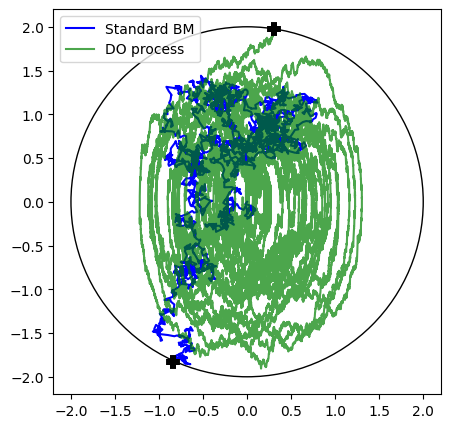

In [ ]:
#plotting the brownian motion and Dufflin Oscillator process together

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(bm_1,bm_2, c='b', label = "Standard BM")
ax.plot(do_1, do_2, c='g', alpha=0.7, label = "DO process")
ax.plot(do_1[-1], do_2[-1], 'k+', mew=10, ms=5)
ax.plot(bm_1[-1], bm_2[-1], 'k+', mew=10, ms=5)
circle = plt.Circle((0,0),r , fill = False)
ax.add_artist(circle)
ax.set_xlim([-1.1*r, 1.1*r])
ax.set_ylim([-1.1*r, 1.1*r])
ax.legend()
#plt.autoscale(False, tight=False)
plt.show()

## 2) Monte Carlo computation of MET (FAIL)

A closed form solution for this problem is not tractable (?), hence we will estimate it with Monte Carlo methods

In [ ]:
n_mc = 100

def do_monte_carlo_timer(x,y):

    times = []

    for k in range(n_mc):
        do_1 = [x]
        do_2 = [y]
        current_norm = 0
        current_steps = 1
        while current_norm < r :
            update_1 = do_2[-1]*dt
            update_2 = -(do_1[-1] + do_1[-1]**3 + 2*zeta*do_2[-1])*dt  \
                + np.sqrt(2 * zeta) *np.random.normal(scale=np.sqrt(dt))
            do_1.append(do_1[-1] + update_1)
            do_2.append(do_2[-1] + update_2)
            current_norm = np.linalg.norm((do_1[-1],do_2[-1]))
            if current_steps >= max_steps - 1 :
                break
            current_steps += 1
        times.append(current_steps)
    return dt * sum(times)/n_mc

monte_carlo_solution = np.vectorize(do_monte_carlo_timer)

In [ ]:
#hyperparams
zeta = 0.08
r = 2
dt = 10**-2
max_steps = 50/dt

#plotting the function
n_points = 300
tt = np.linspace(-1, 1, n_points) * r
xx, yy = np.meshgrid(tt, tt)  # create unit square grid

xx, yy = np.where(xx**2 + yy**2 <= r**2, xx, 0), np.where(xx**2 + yy**2 <= r**2 , yy, 0)
zz = monte_carlo_solution(xx,yy)

KeyboardInterrupt: 

In [ ]:
#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * r , np.sin(a)*r

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)

contour = ax.contourf(xx, yy, zz, levels=50)  # 50 contour levels
ax.set_title("Monte Carlo solution estimate")
cb = fig.colorbar(contour, ax=ax)